In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import cftime


/home/ncs001/.conda/envs/gem-vis/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
history_file = "/space/hall6/sitestore/eccc/crd/ccrn/ccrn_tmp/rcs001/tmp_turnoffsrcmask_cancpl_gem_test_96928/work/cpl_history.nc"
#history_file = "/space/hall6/sitestore/eccc/crd/ccrn/ccrn_tmp/rcs001/tmp_add-flku-flnd_cancpl_gem_test_4004779/work/cpl_history.nc"

In [3]:
 # These are outputs from a CanAM-GEM AMIP run on the 303x115 grid
ds_amip_yin = xr.open_dataset('/home/ncs001/site5/gemdc-tests/yy_out/yy_out_ng/BEGO_2003010100_00000006_yin.nc')
ds_amip_yan = xr.open_dataset('/home/ncs001/site5/gemdc-tests/yy_out/yy_out_ng/BEGO_2003010100_00000006_yan.nc')

In [4]:
hist_data_set = xr.open_dataset(history_file)
hist_data_set

<xarray.Dataset>
Dimensions:               (time: 1280, nlat_atm_yin: 115, nlon_atm_yin: 303,
                           nlat_atm_yang: 115, nlon_atm_yang: 303,
                           nlat_ocn: 292, nlon_ocn: 362)
Coordinates:
  * time                  (time) datetime64[ns] 2003-01-01 ... 2003-06-09T21:...
Dimensions without coordinates: nlat_atm_yin, nlon_atm_yin, nlat_atm_yang,
                                nlon_atm_yang, nlat_ocn, nlon_ocn
Data variables: (12/79)
    lon_atm_yin           (nlat_atm_yin, nlon_atm_yin) float64 ...
    lat_atm_yin           (nlat_atm_yin, nlon_atm_yin) float64 ...
    lon_atm_yang          (nlat_atm_yang, nlon_atm_yang) float64 ...
    lat_atm_yang          (nlat_atm_yang, nlon_atm_yang) float64 ...
    lon_ocn               (nlat_ocn, nlon_ocn) float64 ...
    lat_ocn               (nlat_ocn, nlon_ocn) float64 ...
    ...                    ...
    god_weights_atm_yin   (nlat_atm_yin, nlon_atm_yin) float64 ...
    flno_atm_yin          (nlat_atm_yin, nlon_atm_yin) float64 ...
    cell_area_atm_yang    (nlat_atm_yang, nlon_atm_yang) float64 ...
    god_weights_atm_yang  (nlat_atm_yang, nlon_atm_yang) float64 ...
    flno_atm_yang         (nlat_atm_yang, nlon_atm_yang) float64 ...
    nemo_tmask            (nlat_ocn, nlon_ocn) float64 ...
Attributes:
    CCCma_runid:  default

In [5]:
def get_max_min(vals1, vals2):
    
    # Get max/min values of arrays
    vals1_max_loc = np.unravel_index(vals1.argmax(), vals1.shape)
    vals2_max_loc = np.unravel_index(vals2.argmax(), vals2.shape)
    vals1_min_loc = np.unravel_index(vals1.argmin(), vals1.shape)
    vals2_min_loc = np.unravel_index(vals2.argmin(), vals2.shape)
    
    vals1_max = vals1[vals1_max_loc[0], vals1_max_loc[1]]
    vals2_max = vals2[vals2_max_loc[0], vals2_max_loc[1]]
    vals1_min = vals1[vals1_min_loc[0], vals1_min_loc[1]]
    vals2_min = vals2[vals2_min_loc[0], vals2_min_loc[1]]
    
    max_value = max(vals1_max, vals2_max)
    min_value = min(vals1_min, vals2_min)
    
    return (max_value, min_value)


In [12]:
def plot_yg_fields(yin_rlon, yin_rlat, yin_field, yan_rlon, yan_rlat, yan_field, step, **kwargs):
    '''Create a compound figure of Yin/Yang panels, plotted in rotated coordinates.
    '''
    #yin_vals  = yin_field.isel(time=step)#.values
    #yan_vals = yan_field.isel(time=step)#.values
    #vals_max, vals_min = get_max_min(yin_vals, yan_vals)
    vals_min =0
    vals_max=320
    main_title = f"{yin_field.long_name} [{yin_field.units}]"
    sub_title = f"Max = {vals_max}, Min = {vals_min}"
    
    # hack to override min if the units are Kelvin
    if yin_field.units == "K":
        vals_min = 250
    
    fig = plt.figure(figsize=(8,14))

    rotated_yan = ccrs.RotatedPole(pole_latitude=8.050,pole_longitude=352.579, central_rotated_longitude=180)
    rotated_yin = ccrs.RotatedPole(pole_latitude=31.758,pole_longitude=87.597)
    data_crs = ccrs.PlateCarree()

    axes_class = (GeoAxes,
                      dict(projection=data_crs))


    grid = AxesGrid(fig, 111, axes_class=axes_class,
                        nrows_ncols=(2, 1),
                        axes_pad=0.25,
                        cbar_location='right',
                        cbar_mode='single',
                        cbar_pad=0.1,
                        cbar_size='3%',
                        label_mode='')  # note the empty label_modead=0.05

    axl = grid[0]
    axl.set_title(main_title)
    axl.pcolormesh(yin_rlon, yin_rlat, yin_field ,transform=rotated_yin, vmin = vals_min, vmax = vals_max, **kwargs)
    axl.coastlines(linewidth=0.1)  

    axr = grid[1]
    axr.set_title(sub_title)
    cm = axr.pcolormesh(yan_rlon+180, yan_rlat, yan_field, transform=rotated_yan, vmin = vals_min, vmax = vals_max, **kwargs)
    axr.coastlines(linewidth=0.1)
    grid.cbar_axes[0].colorbar(cm,extend='both')

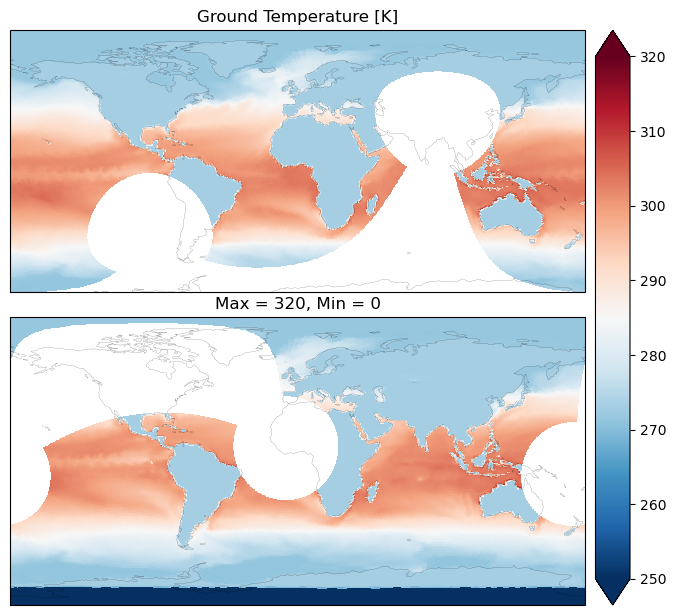

In [15]:
step = 3

# Set vars
#atm_var = ( hist_data_set.BEGO_atm_yin, hist_data_set.BEGO_atm_yang )
#atm_var = ( hist_data_set.UFSO_atm_yin, hist_data_set.UFSO_atm_yang )
#atm_var = ( hist_data_set.VFSO_atm_yin, hist_data_set.VFSO_atm_yang )
atm_var = ( hist_data_set.GT_atm_yin, hist_data_set.GT_atm_yang )
ocn_var = hist_data_set.O_SSTSST
#ocn_var = hist_data_set.O_Wind10

# Plot
plot_yg_fields(ds_amip_yin.rlon, ds_amip_yin.rlat, hist_data_set.GT_atm_yin.isel(time=300), 
               ds_amip_yan.rlon, ds_amip_yan.rlat, hist_data_set.GT_atm_yang.isel(time=300), step = step,
               cmap='RdBu_r')

#plt.figure()
#ocn_var.isel(time = step).plot.pcolormesh(cmap='RdBu_r')
#plt.title(ocn_var.name)



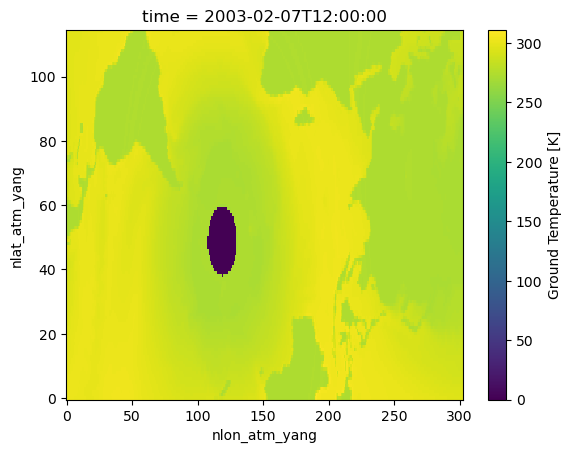

In [16]:
hist_data_set.GT_atm_yang.isel(time=300).plot()